# BIRD SPECIES CLASSIFICATION

In [1]:
import os
from random import randrange
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.models as models
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_dir = 'C:/Users/saikumar/OneDrive/Desktop/archive'
species = os.listdir(data_dir + "/train")
num_classes = len(species)
print("num species:", num_classes)
print({cls: len(os.listdir(data_dir + f"/train/{cls}/")) for cls in sorted(species)})

num species: 525
{'ABBOTTS BABBLER': 163, 'ABBOTTS BOOBY': 180, 'ABYSSINIAN GROUND HORNBILL': 179, 'AFRICAN CROWNED CRANE': 135, 'AFRICAN EMERALD CUCKOO': 154, 'AFRICAN FIREFINCH': 137, 'AFRICAN OYSTER CATCHER': 155, 'AFRICAN PIED HORNBILL': 187, 'AFRICAN PYGMY GOOSE': 179, 'ALBATROSS': 132, 'ALBERTS TOWHEE': 161, 'ALEXANDRINE PARAKEET': 165, 'ALPINE CHOUGH': 166, 'ALTAMIRA YELLOWTHROAT': 150, 'AMERICAN AVOCET': 179, 'AMERICAN BITTERN': 170, 'AMERICAN COOT': 158, 'AMERICAN DIPPER': 193, 'AMERICAN FLAMINGO': 164, 'AMERICAN GOLDFINCH': 133, 'AMERICAN KESTREL': 155, 'AMERICAN PIPIT': 179, 'AMERICAN REDSTART': 139, 'AMERICAN ROBIN': 147, 'AMERICAN WIGEON': 187, 'AMETHYST WOODSTAR': 130, 'ANDEAN GOOSE': 134, 'ANDEAN LAPWING': 144, 'ANDEAN SISKIN': 154, 'ANHINGA': 153, 'ANIANIAU': 150, 'ANNAS HUMMINGBIRD': 139, 'ANTBIRD': 150, 'ANTILLEAN EUPHONIA': 139, 'APAPANE': 154, 'APOSTLEBIRD': 153, 'ARARIPE MANAKIN': 152, 'ASHY STORM PETREL': 188, 'ASHY THRUSHBIRD': 164, 'ASIAN CRESTED IBIS': 156, 'AS

In [7]:
transform = tt.Compose(
    [
        tt.ToTensor(), 
    ]
)

# Create datasets
train_ds = ImageFolder(data_dir+'/train', transform)
valid_ds = ImageFolder(data_dir+'/test', transform)

# set the batch size
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

classes = valid_ds.classes

BALTIMORE ORIOLE


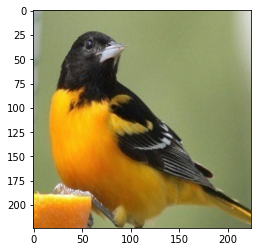

In [8]:
def show_example(data):
    [img, label] = data
    print(classes[label])
    plt.imshow(img.permute(1, 2, 0))
    
# show a bird 
image_number = randrange(20000)
show_example(train_ds[image_number])

In [9]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

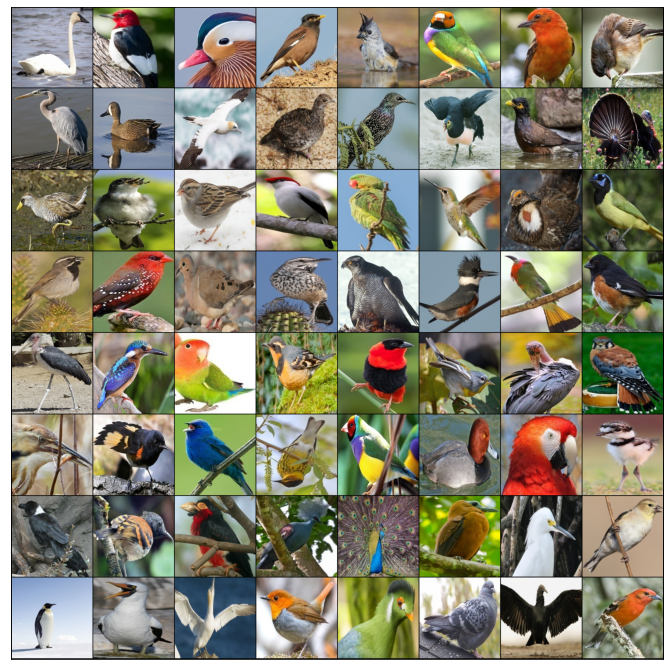

In [10]:
show_batch(train_dl)

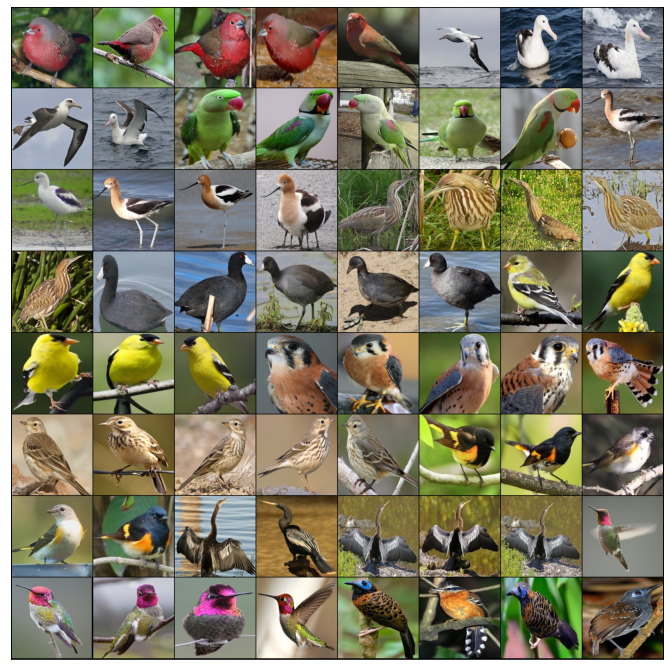

In [10]:
show_batch(valid_dl)

In [11]:
# pick a device
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
    

device = get_default_device()
device

device(type='cuda')

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [19]:
class BirdResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [20]:
model = to_device(BirdResnet(), device)
model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


BirdResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [16]:
torch.cuda.empty_cache()
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
to_device(model, device)

# print outputs for a single batch
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('all outputs:', out)
    break
    
# show the highest probability values and their index/classes
values, indices = out.max(0)
print("max values", values)
print("max indices", indices)
print("guesses", [classes[index] for index in indices])

images.shape: torch.Size([64, 3, 224, 224])
out.shape: torch.Size([64, 200])
all outputs: tensor([[0.7433, 0.3245, 0.2520,  ..., 0.5540, 0.6418, 0.5370],
        [0.6289, 0.5875, 0.3886,  ..., 0.8537, 0.4299, 0.3644],
        [0.6529, 0.5377, 0.3257,  ..., 0.7283, 0.5583, 0.3778],
        ...,
        [0.6008, 0.5316, 0.3851,  ..., 0.7793, 0.4925, 0.3513],
        [0.5916, 0.4538, 0.4636,  ..., 0.8360, 0.5310, 0.3895],
        [0.4327, 0.4612, 0.3127,  ..., 0.6833, 0.7441, 0.2921]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
max values tensor([0.8161, 0.6912, 0.7135, 0.4302, 0.7683, 0.8082, 0.6554, 0.8708, 0.7564,
        0.7747, 0.8047, 0.6672, 0.8419, 0.7237, 0.8020, 0.8670, 0.6932, 0.7837,
        0.7259, 0.8288, 0.7197, 0.5398, 0.7139, 0.7236, 0.7171, 0.8426, 0.6652,
        0.7720, 0.8192, 0.9151, 0.8054, 0.9683, 0.6760, 0.8105, 0.7900, 0.8988,
        0.7279, 0.5929, 0.8511, 0.8342, 0.6503, 0.7193, 0.7219, 0.7721, 0.4405,
        0.6511, 0.7456, 0.5414, 0.6525, 0.4844, 0.

In [17]:
# create the test dataset
test_dataset = ImageFolder(data_dir+'/test', tt.ToTensor())

#methods to pick a random image and make a prediciton
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_dataset.classes[preds[0].item()]

def get_random_test_image(dataset):
    rand_num = randrange(len(dataset))
    return dataset[rand_num]

Label: ROCK DOVE , Predicted: BLACK-CAPPED CHICKADEE


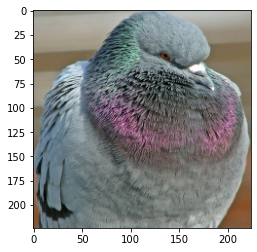

In [18]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: CASPIAN TERN , Predicted: BLACK-CAPPED CHICKADEE


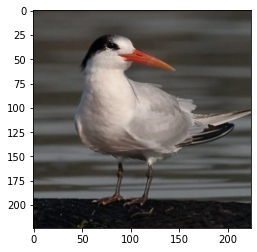

In [19]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: EURASIAN MAGPIE , Predicted: BLACK-CAPPED CHICKADEE


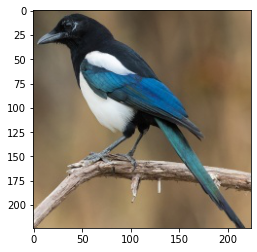

In [20]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [12]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 5.315706253051758, 'val_acc': 0.0029296875}]

In [23]:
# freeze the model to only train the last layer
model.freeze()


In [30]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [32]:
history = fit(num_epochs, lr, model, train_dl, valid_dl, opt_func)

Epoch [0], train_loss: 4.6208, val_loss: 4.4590, val_acc: 0.4419
Epoch [1], train_loss: 4.4502, val_loss: 4.4725, val_acc: 0.4245
Epoch [2], train_loss: 4.4137, val_loss: 4.4025, val_acc: 0.6001
Epoch [3], train_loss: 4.3948, val_loss: 4.3751, val_acc: 0.6980
Epoch [4], train_loss: 4.3860, val_loss: 4.3724, val_acc: 0.6541
Epoch [5], train_loss: 4.3722, val_loss: 4.3566, val_acc: 0.7482
Epoch [6], train_loss: 4.3673, val_loss: 4.3589, val_acc: 0.7323
Epoch [7], train_loss: 4.3624, val_loss: 4.3584, val_acc: 0.7411
Epoch [8], train_loss: 4.3573, val_loss: 4.3751, val_acc: 0.7015
Epoch [9], train_loss: 4.3554, val_loss: 4.3704, val_acc: 0.7123


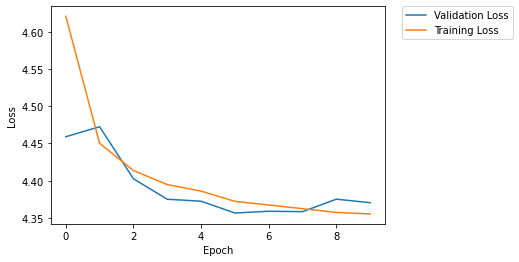

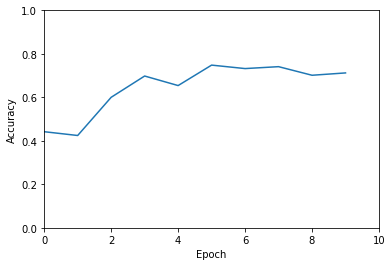

In [33]:
val_loss = [hist['val_loss'] for hist in history]
train_loss = [hist['train_loss'] for hist in history]
val_acc = [hist['val_acc'] for hist in history]
plt.plot(val_loss, label="Validation Loss")
plt.plot(train_loss, label="Training Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

plt.plot()
plt.plot(val_acc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.axis([0, 10, 0, 1])
plt.show()

Label: PARADISE TANAGER , Predicted: PARADISE TANAGER


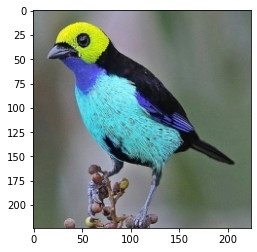

In [34]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: EVENING GROSBEAK , Predicted: EVENING GROSBEAK


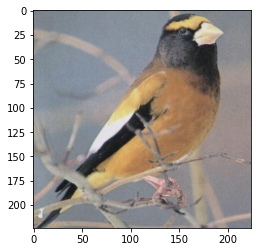

In [35]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: COMMON GRACKLE , Predicted: COMMON GRACKLE


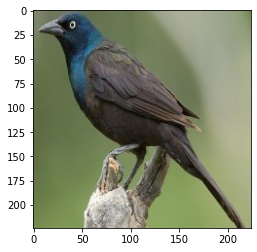

In [36]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: CANARY , Predicted: CANARY


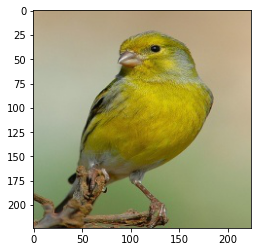

In [37]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: BLACK VULTURE , Predicted: WHITE NECKED RAVEN


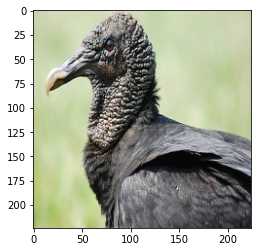

In [38]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: MYNA , Predicted: MYNA


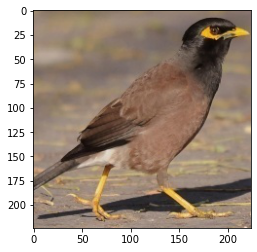

In [39]:
img, label = test_dataset[600]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

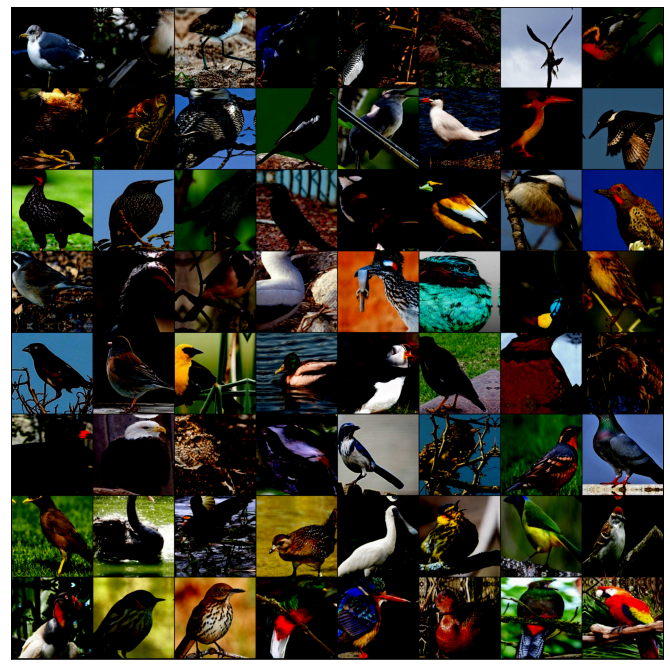

In [14]:
# some data transforms and augmentation to improve accuracy

stats = ((0.5,0.5,0.5), (0.5,0.5,0.5))
train_transform = tt.Compose(
    [
        tt.RandomCrop(200, padding=20, padding_mode='reflect'),
        tt.RandomHorizontalFlip(),
        tt.ToTensor(),
        tt.Normalize(*stats),
    ]
)
valid_transform = tt.Compose(
    [
        tt.ToTensor(), 
        tt.Normalize(*stats)
    ]
)

# Create datasets
train_ds = ImageFolder(data_dir+'/train', train_transform)
valid_ds = ImageFolder(data_dir+'/valid', valid_transform)
test_ds = ImageFolder(data_dir+'/test', valid_transform)

# set the batch size
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

classes = valid_ds.classes

show_batch(train_dl)

In [15]:
# a slightly more advanced training loop for increased accuracy
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
class BirdResnet2(BirdResnet):
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [22]:
torch.cuda.empty_cache()
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
model = to_device(BirdResnet2(), device)
model

BirdResnet2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [23]:
epochs = 15
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [24]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 5.321384429931641, 'val_acc': 0.00390625}]

In [25]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00015, train_loss: 4.7889, val_loss: 4.4391, val_acc: 0.8697
Epoch [1], last_lr: 0.00044, train_loss: 4.4372, val_loss: 4.4048, val_acc: 0.7195
Epoch [2], last_lr: 0.00076, train_loss: 4.4404, val_loss: 4.4752, val_acc: 0.5288
Epoch [3], last_lr: 0.00097, train_loss: 4.4495, val_loss: 4.4381, val_acc: 0.5522
Epoch [4], last_lr: 0.00099, train_loss: 4.4494, val_loss: 4.4529, val_acc: 0.5168
Epoch [5], last_lr: 0.00095, train_loss: 4.4355, val_loss: 4.4244, val_acc: 0.5990
Epoch [6], last_lr: 0.00087, train_loss: 4.4278, val_loss: 4.3933, val_acc: 0.7016
Epoch [7], last_lr: 0.00075, train_loss: 4.4165, val_loss: 4.3924, val_acc: 0.6989
Epoch [8], last_lr: 0.00061, train_loss: 4.4011, val_loss: 4.3752, val_acc: 0.7332
Epoch [9], last_lr: 0.00046, train_loss: 4.3891, val_loss: 4.3616, val_acc: 0.7840
Epoch [10], last_lr: 0.00032, train_loss: 4.3719, val_loss: 4.3493, val_acc: 0.8353
Epoch [11], last_lr: 0.00019, train_loss: 4.3567, val_loss: 4.3382, val_acc: 0.8561
Ep

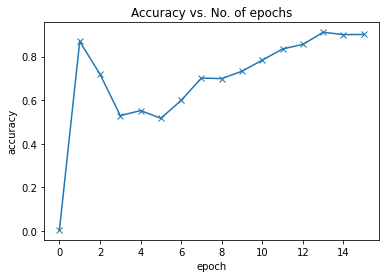

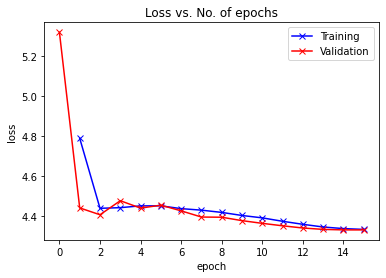

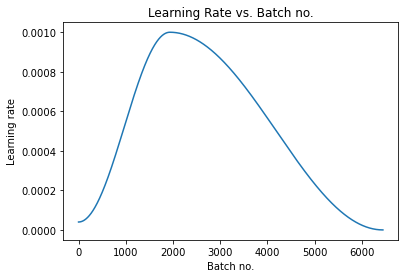

In [26]:
# plot accuracy
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')
plt.show()

# plot losses
train_losses = [x.get('train_loss') for x in history]
val_losses = [x['val_loss'] for x in history]
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs')
plt.show()

# plor learning rates
lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.plot(lrs)
plt.xlabel('Batch no.')
plt.ylabel('Learning rate')
plt.title('Learning Rate vs. Batch no.')
plt.show()

Label: TRUMPTER SWAN , Predicted: TRUMPTER SWAN


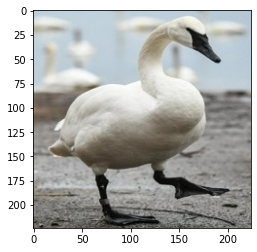

In [109]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: EURASIAN MAGPIE , Predicted: EURASIAN MAGPIE


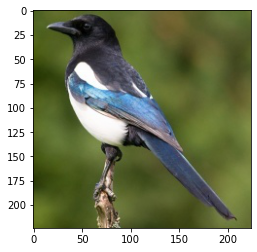

In [111]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: PUFFIN , Predicted: PUFFIN


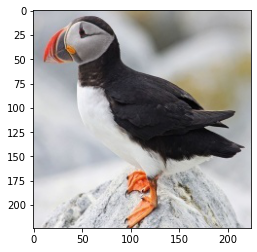

In [113]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))